<a href="https://colab.research.google.com/github/LeliaPlusPlus/BreathingDisparities/blob/main/Copy_of_MLHCProject_DataExplore_Clustering_for_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLHC Project
Goal: Using traditional demographic labels and SDoH can we link them to potential disparities in health outcomes in intibated ICU patients using MIMIC data. 

Some code drawn from a GitHub that is not shared.   
Data from: https://physionet.org/content/mimiciv/2.2/ 

Most recent query pull was 4/6/2023

## Imports and Downloading Data

Imports used to Download the data directly from the query pulled from Google Big Query. Then the csv was saved locally for future runtimes. 

###Imports

In [ ]:
from google.colab import auth
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
auth.authenticate_user()

## Reupload and Clean Data 
We cleaned the data by keeping on intubated patients and 23 relavent features. 

In [ ]:
# Imports
import sys
import os
from matplotlib import pyplot as plt
# get path to lib folder which is one level up from the current directory
lib_path = os.path.abspath(os.path.join('..', 'lib'))
# append the path to 'lib' to access custom modules
sys.path.append(lib_path)
from pathlib import Path
from sklearn.cluster import KMeans
import pandas as pd
from matplotlib import cm
import json
!pip install hypernetx
import hypernetx as hnx
!pip install hypercluster
import hypercluster as hc

In [ ]:
# Get general demographic table from downloads ##LOAD FILE FROM DESKTOP
raw_df = pd.read_csv('output_updated(4:6:23).csv')

In [ ]:
# Select Features to keep 
df = raw_df.copy()
# keep only the following columns:
features_to_keep = [
    'subject_id', 'hadm_id', 'stay_id', 'los', 'age', 'height', 'weight', 'bmi', 'race', 'marital_status', 'insurance',
    'fluent_english', 'gender', 'hospital_expire_flag', 'primary_diagnosis',
    'icd_version', 'avg_sofa', 'hidden_hypoxemia_percentage',
    'max_delta_SaO2SpO2','intubation_duration_hour', 'number_of_turning',
    'frequency_of_turning_hour', 'number_of_oral_care__condensed',
    'frequency_of_oral_care_hour__condensed', 'oral_care_type']

df = df[features_to_keep]

In [ ]:
# Only keep patients that have been intubated
df = df[~df['intubation_duration_hour'].isna()]

## Mapping Data to Numerical Features 
Categorical Features were mapped to Numerical values. 

In [ ]:
from logging import raiseExceptions
# Convert all features from raw_df to numeric

# 1. Convert gender from M/F to 0/1
df["gender"] = raw_df.gender.map({"M": 0, "F": 1})

# 2. Mark all black patients as 1 and all non-white patients as 0 (this is a simplification that should be explored further) ERROR: divides data to 1 = black and 0 is everyone else
  #ERROR: df["race"] = raw_df.race.str.contains("BLACK").astype(int)
# new race map that does black, white, other with room to expand 
race_map = {} 
for i, race in enumerate(raw_df.race.unique()):
  if "BLACK" in race:
    race_map[race] = 1
  elif "WHITE" in race:
    race_map[race] = 2
  elif "HISPANIC" in race or "PORTUGUESE" in race: 
    race_map[race] = 3
  else:
    race_map[race] = 0
print(race_map)
df["race"] = raw_df.race.map(race_map)

# 3. Convert english proficiency from boolean to 0/1
df["fluent_english"] = raw_df.fluent_english.map({True: 1, False: 0})

# 4. Convert diagnosis from string to numeric
diagno_map = {diagno:val for val, diagno in enumerate(raw_df.primary_diagnosis.unique())}
df["primary_diagnosis"] = raw_df.primary_diagnosis.map(diagno_map)

# 5. Convert oral care type from string to numeric
oc_map = {oc:val for val, oc in enumerate(raw_df.oral_care_type.unique())}
df["oral_care_type"] = raw_df.oral_care_type.map(oc_map)

# 6. Marital Status 
df['marital_status'] = raw_df.marital_status.map({'SINGLE':0, 'MARRIED':2, 'WIDOW':1, 'DIVORCED':3})

# 7. Insurance 
df['insurance'] = raw_df.insurance.map({'Other':0, 'Medicare':2, 'Medicaid':1})

# 8. Convert everything to float
df = df.astype(float)

## Exploratory Data Analysis

We looked at the demographics present in the data. The missingness of the data and the general descriptive statistics for each feature. 

In [ ]:
# Gender Distribution 
import matplotlib.pyplot as plt
import numpy as np
count = df['gender'].value_counts(dropna=False)

plt.pie(count, labels=["Male", "Female"], autopct='%1.1f%%')
plt.show()

In [ ]:
# Fluency in English 
count = df['fluent_english'].value_counts(dropna=False)
print(count)
plt.pie(count, labels=["Fluent English", "Non-Fluent English"], autopct='%1.1f%%')
plt.show()

In [ ]:
# Race 
import matplotlib.pyplot as plt
import numpy as np
count = df['race'].value_counts(dropna=False)
print(count)
plt.pie(count, labels=["White", "Other", "Black", "Hispanic", ], autopct='%1.1f%%')
plt.show()

In [ ]:
# Number of pts on Vents 
pts_intibated = df['intubation_duration_hour'].isna().sum()
print(pts_intibated)
total_pts = len(df['intubation_duration_hour'].tolist())
print(total_pts)

In [ ]:
# Missingness of the df 
missingness = {}
percent_missing = {}
for col in df.columns:
  missingness[col] = df[col].isna().sum()
  percent_missing[col] = df[col].isna().sum() / len(df[col].tolist())

In [ ]:
# Plot percent missing 
plt.bar(*zip(*percent_missing.items()))
plt.xticks(rotation=90)
plt.title("The Percent Missing of the Data in each Column")
plt.show()

In [ ]:
# Descriptive Stats on Columns
stats = df.describe()
stats

## Hyperclustering First Attempts 
Not Valid because was trying to use K-means which can only be used on numerical data.

### Make Hyperclusters A -- Mentor Example

In [ ]:
# Create the Hypercluster Sets

hyperedge0 = ["gender", "race", "age", "fluent_english", "weight", "bmi", "height"]
hyperedge1 = ["weight", "bmi", "avg_sofa", "primary_diagnosis", "icd_version", "height"]
hyperedge2 = ["hidden_hypoxemia_percentage", "los", "hospital_expire_flag"]
hyperedge3 = ["number_of_turning", "frequency_of_turning_hour", "number_of_oral_care__condensed", "oral_care_type"] # Removed target from sets== "frequency_of_oral_care_hour__condensed"
hyperedges = [hyperedge0, hyperedge1, hyperedge2, hyperedge3]
hyperedges_name = ["demographics", "clinical", "outcomes", "interventions"]

In [ ]:
# Visualize the hypergraph
scenes = {
    name: tuple(hyperedge) for name, hyperedge in zip(hyperedges_name, hyperedges)
}
H = hnx.Hypergraph(scenes)
hnx.drawing.draw(H)
plt.savefig("hypergraph.png")
plt.show()

In [ ]:
from typing import List

# Define custom metrics
  # Here, the mean of the correlation between each feature in the hyperedge
# and the target (frequency of turning disparity)
def mean_correlation(df: pd.DataFrame, e: List[str], target: str = "frequency_of_oral_care_hour__condensed"):
    print(df[e + [target]].corr().loc[target, e].mean())
    return df[e + [target]].corr().loc[target, e].mean()

# Put all the metrics into a list
all_metrics = [("mean_correlation", mean_correlation)]

In [ ]:
# Create a dataset with the hyperedges and the custom metric
X = pd.DataFrame()
for metric_name, metric in all_metrics:
    l = []
    for i, e in enumerate(hyperedges):
        print(e)
        l.append(metric(df, e))
    X[metric_name] = l
X

In [ ]:
from collections import defaultdict

# Train multiple clustering algorithms (can use Vulpes later, scikit learn in the meanwhile)
n_clusters = 2  # choose the number of clusters, supervised approach here
clustering = KMeans(n_clusters=n_clusters, random_state=42)
clustering.fit(X)
clusters = clustering.predict(X)

In [ ]:
# Visualize clusters?
clusters_dic = defaultdict(list)
for cluster_id, hyperedge_name in zip(clusters, hyperedges_name):
    clusters_dic[cluster_id].append(hyperedge_name)
scenes_clusters = {
    i: tuple(cluster) for i, cluster in clusters_dic.items()
}
H_clusters = hnx.Hypergraph(scenes_clusters)
hnx.drawing.draw(H_clusters)
plt.savefig("clusters.png")
plt.show()

###  Hyperclusters B -- Exploring Data Techniques


In [ ]:
df.columns

In [ ]:
# Another Set 
hyperedge0 = ["gender", "race", "age", "fluent_english"]
hyperedge1 = ["weight", "bmi", "avg_sofa", "primary_diagnosis", "icd_version", "height"]
hyperedge2 = ["hidden_hypoxemia_percentage", 'max_delta_SaO2SpO2', "los", "hospital_expire_flag"]
hyperedge3 = ["frequency_of_oral_care_hour__condensed", "number_of_oral_care__condensed", "oral_care_type"] # Removed target from sets== "number_of_turning", "frequency_of_turning_hour"
hyperedges = [hyperedge0, hyperedge1, hyperedge2, hyperedge3]
hyperedges_name = ["demographics", "clinical", "outcomes", "interventions"]

In [ ]:
from typing import List

# Define custom metrics
  # Here, the mean of the correlation between each feature in the hyperedge
# and the target (frequency of turning disparity)
def mean_correlation(df: pd.DataFrame, e: List[str], target: str = "frequency_of_turning_hour"):
    print(df[e + [target]].corr().loc[target, e].mean())
    return df[e + [target]].corr().loc[target, e].mean()

# Put all the metrics into a list
all_metrics = [("mean_correlation", mean_correlation)]

In [ ]:
# Create a dataset with the hyperedges and the custom metric
X = pd.DataFrame()
for metric_name, metric in all_metrics:
    l = []
    for i, e in enumerate(hyperedges):

        l.append(metric(df, e))
    X[metric_name] = l
X

In [ ]:
# from collections import defaultdict

# Train multiple clustering algorithms (can use Vulpes later, scikit learn in the meanwhile)
n_clusters = 2  # choose the number of clusters, supervised approach here
clustering = KMeans(n_clusters=n_clusters, random_state=42)
clustering.fit(X)
clusters = clustering.predict(X)

In [ ]:
# Visualize clusters?
clusters_dic = defaultdict(list)
for cluster_id, hyperedge_name in zip(clusters, hyperedges_name):
    clusters_dic[cluster_id].append(hyperedge_name)
scenes_clusters = {
    i: tuple(cluster) for i, cluster in clusters_dic.items()
}
H_clusters = hnx.Hypergraph(scenes_clusters)
hnx.drawing.draw(H_clusters)
plt.savefig("turning_clusters.png")
plt.show()

### Hyperclustering C 

In [ ]:
# Supervised Sets 
hyperedge0 = ["gender", "race", "age", "weight", "bmi", "height"]
hyperedge1 = ["weight", "bmi", "avg_sofa", "primary_diagnosis", "icd_version", "height"]
hyperedge2 = ["hidden_hypoxemia_percentage", "los", "hospital_expire_flag"]
hyperedge3 = ["number_of_turning", "frequency_of_turning_hour", "number_of_oral_care__condensed", "oral_care_type"] # Removed target from sets== "frequency_of_oral_care_hour__condensed"
hyperedge4 = ["bmi", "marital_status", "fluent_english"]
hyperedges = [hyperedge0, hyperedge1, hyperedge2, hyperedge3, hyperedge4]
hyperedges_name = ["demographics", "clinical", "outcomes", "interventions", "SDoH"]

In [ ]:
from typing import List

# Define custom metrics
  # Here, the mean of the correlation between each feature in the hyperedge
# and the target (frequency of turning disparity)
def mean_correlation(df: pd.DataFrame, e: List[str], target: str = "frequency_of_oral_care_hour__condensed"):
    print(df[e + [target]].corr().loc[target, e].mean())
    return df[e + [target]].corr().loc[target, e].mean()

# Put all the metrics into a list
all_metrics = [("mean_correlation", mean_correlation)]

In [ ]:
# Create a dataset with the hyperedges and the custom metric
X = pd.DataFrame()
for metric_name, metric in all_metrics:
    l = []
    for i, e in enumerate(hyperedges):
        print(e)
        l.append(metric(df, e))
    X[metric_name] = l
X

In [ ]:
#Train cluster model 
# Train multiple clustering algorithms (can use Vulpes later, scikit learn in the meanwhile)
n_clusters = 2  # choose the number of clusters, supervised approach here
clustering = KMeans(n_clusters=n_clusters, random_state=42)
clustering.fit(X)
clusters = clustering.predict(X)

In [ ]:
# Visualize clusters?
clusters_dic = defaultdict(list)
for cluster_id, hyperedge_name in zip(clusters, hyperedges_name):
    clusters_dic[cluster_id].append(hyperedge_name)
scenes_clusters = {
    i: tuple(cluster) for i, cluster in clusters_dic.items()
}
H_clusters = hnx.Hypergraph(scenes_clusters)
hnx.drawing.draw(H_clusters)
plt.savefig("clusters.png")
plt.show()

## Updated Hyperclustering Technique K-Prototype
New Approach takes into account categorical and numerical data that is mixed together.

*  Why: https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0  
* Implementation: https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb 



#### Data Preprocessing

In [ ]:
#Identify the columns with numerical versus categorical data
numerical_features = ['los', 'age', 'height', 'weight', 'bmi', 'frequency_of_oral_care_hour__condensed', 
                      'frequency_of_turning_hour', 'max_delta_SaO2SpO2', 'intubation_duration_hour',
                      'number_of_turning', 'number_of_oral_care__condensed', 'hidden_hypoxemia_percentage', 'avg_sofa']
categorical_features = ['race', 'marital_status', 'insurance', 'fluent_english', 
                        'gender', "icd_version", 'primary_diagnosis', 'oral_care_type',
                        "hospital_expire_flag"]


In [ ]:
## Imports for K-prototype clustering

# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
!pip install kmodes
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Preprocessing Data
 # 1. Remove Unneccessary cols and get the position of categorical columns

df = df.drop(['subject_id', 'hadm_id',  'stay_id'], axis=1)

catColumnsPos = [df.columns.get_loc(col) for col in categorical_features]
print('Categorical columns           : {}'.format(categorical_features))
print('Categorical columns position  : {}'.format(catColumnsPos))

In [ ]:
# 2. Replace NaN Values (see data exploration for missing analysis)
  
### Descriptive Stats on Columns
stats = df.describe()

### Replace NaN vals in each column with the mean
cluster_df = df.copy()

for col in df.columns:
  for i in df[col].isnull().to_numpy().nonzero():
    
    cluster_df[col].iloc[i] = stats[col]['mean']


In [ ]:
# 3. Normalize the numerical columns
import sklearn.preprocessing 
from sklearn.preprocessing import MinMaxScaler

norm_df = cluster_df.copy()
for col in cluster_df:
  
  if str(col) in categorical_features:
    print(col)
    print(categorical_features)
  else:
    norm_df[col] = MinMaxScaler().fit_transform(np.array(cluster_df[col]).reshape(-1,1))


In [ ]:
# 5. Alg takes imput as matrix not Dataframe
dfMatrix = norm_df.to_numpy()
print(np.argwhere(np.isnan(dfMatrix)))

#### Visualize Data Pre-Clustering

In [ ]:
#!pip install umap-learn
import umap.umap_ as umap

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(catColumnsPos) / norm_df.shape[1]

#Embedding numerical & categorical
numColumnsPos = [col for col in norm_df if col not in categorical_features]
numerical = norm_df[numColumnsPos]
categorical = norm_df[categorical_features]
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                          fit1._initial_alpha, fit1._a, fit1._b, fit1.repulsion_strength, 
                                          fit1.negative_sample_rate, 200, 'random', np.random, 
                                          fit1.metric, fit1._metric_kwds, False, 
                                          fit1.densmap, output_dens=False)



In [ ]:
# Visualize 
plt.figure(figsize=(20, 10))
plt.scatter(embedding[0][:,0], embedding[0][:,1], s=2, cmap='Spectral', alpha=1.0)
plt.show()

#### Outliers Exploration

In [ ]:
# Find outlier embeddings 
outliers = []
index = 0
for x, y in embedding[0]:
  if 6 < x < 7.5 and -1.5 < y < 0.2:
    outliers.append(index)
  index += 1

In [ ]:
# Second Outlier Group 
out2 = []
index = 0
for x, y in embedding[0]:
  if 7 < x < 8 and -10 < y < -5:
    out2.append(index)
  index += 1

In [ ]:
print(len(outliers))
print(len(out2))

In [ ]:
df_outlier = norm_df[norm_df.index.isin(outliers)]
print(df_outlier)

In [ ]:
df_out2= norm_df[norm_df.index.isin(out2)]
print(df_out2)

In [ ]:
# Cluster Counts
print(df_outlier["Cluster Labels"].value_counts())
print(norm_df["Cluster Labels"].value_counts())
print(df_out2["Cluster Labels"].value_counts())

In [ ]:
# stats on outliers by clusters 

table = df_outlier.groupby('Cluster Labels').agg(
    {  
        'los': 'mean',
        'age': 'mean',
        
        #'oral_care_type': lambda x: x.value_counts().index[0],
        #'height': 'mean',
        #'weight': 'mean',
        #'bmi': 'mean',
        'race': lambda x: (x.value_counts().index[0]),
        'marital_status': lambda x: (x.value_counts().index[0]),
        'insurance': lambda x: (x.value_counts().index[0]),

        #'fluent_english': lambda x: (x.value_counts().index[0]),
        'gender': lambda x: (x.value_counts().index[0]),
        #'hospital_expire_flag': lambda x: (x.value_counts().index[0]),
        'primary_diagnosis': lambda x: (x.value_counts().index[0]),
        #'icd_version': lambda x: (x.value_counts().index[0]),
         
        'avg_sofa': 'mean',
        'hidden_hypoxemia_percentage': 'mean',
        #'max_delta_SaO2SpO2': 'mean',

        'intubation_duration_hour': 'mean',
        'number_of_turning': 'mean',
        'frequency_of_turning_hour': 'mean',
        'number_of_oral_care__condensed': 'mean',
        'frequency_of_oral_care_hour__condensed': 'mean',
        
        
        
    }
).reset_index()

print(table)

In [ ]:
table = df_out2.groupby('Cluster Labels').agg(
    {  
        'los': 'mean',
        'age': 'mean',
        
        #'oral_care_type': lambda x: x.value_counts().index[0],
        #'height': 'mean',
        #'weight': 'mean',
        #'bmi': 'mean',
        'race': lambda x: (x.value_counts().index[0]),
        'marital_status': lambda x: (x.value_counts().index[0]),
        'insurance': lambda x: (x.value_counts().index[0]),

        #'fluent_english': lambda x: (x.value_counts().index[0]),
        'gender': lambda x: (x.value_counts().index[0]),
        #'hospital_expire_flag': lambda x: (x.value_counts().index[0]),
        'primary_diagnosis': lambda x: (x.value_counts().index[0]),
        #'icd_version': lambda x: (x.value_counts().index[0]),
         
        'avg_sofa': 'mean',
        'hidden_hypoxemia_percentage': 'mean',
        #'max_delta_SaO2SpO2': 'mean',

        'intubation_duration_hour': 'mean',
        'number_of_turning': 'mean',
        'frequency_of_turning_hour': 'mean',
        'number_of_oral_care__condensed': 'mean',
        'frequency_of_oral_care_hour__condensed': 'mean',
        
        
        
    }
).reset_index()

print(table)

In [ ]:
# Stats by Outliers vs Whole dataset without cluster label groupings

whole_table = norm_df.agg(
    {  
        'los': 'mean',
        'age': 'mean',
        'oral_care_type': lambda x: x.value_counts().index[0],
        'height': 'mean',
        'weight': 'mean',
        'bmi': 'mean',
        'race': lambda x: (x.value_counts().index[0]),
        'marital_status': lambda x: (x.value_counts().index[0]),
        'insurance': lambda x: (x.value_counts().index[0]),
        'fluent_english': lambda x: (x.value_counts().index[0]),
        'gender': lambda x: (x.value_counts().index[0]),
        'hospital_expire_flag': lambda x: (x.value_counts().index[0]),
        'primary_diagnosis': lambda x: (x.value_counts().index[0]),
        'icd_version': lambda x: (x.value_counts().index[0]), 
        'avg_sofa': 'mean',
        'hidden_hypoxemia_percentage': 'mean',
        'max_delta_SaO2SpO2': 'mean',
        'intubation_duration_hour': 'mean',
        'number_of_turning': 'mean',
        'frequency_of_turning_hour': 'mean',
        'number_of_oral_care__condensed': 'mean',
        'frequency_of_oral_care_hour__condensed': 'mean',  
    }
).reset_index()

out_table = df_outlier.agg(
    {  
        'los': 'mean',
        'age': 'mean',
        'oral_care_type': lambda x: x.value_counts().index[0],
        'height': 'mean',
        'weight': 'mean',
        'bmi': 'mean',
        'race': lambda x: (x.value_counts().index[0]),
        'marital_status': lambda x: (x.value_counts().index[0]),
        'insurance': lambda x: (x.value_counts().index[0]),
        'fluent_english': lambda x: (x.value_counts().index[0]),
        'gender': lambda x: (x.value_counts().index[0]),
        'hospital_expire_flag': lambda x: (x.value_counts().index[0]),
        'primary_diagnosis': lambda x: (x.value_counts().index[0]),
        'icd_version': lambda x: (x.value_counts().index[0]), 
        'avg_sofa': 'mean',
        'hidden_hypoxemia_percentage': 'mean',
        'max_delta_SaO2SpO2': 'mean',
        'intubation_duration_hour': 'mean',
        'number_of_turning': 'mean',
        'frequency_of_turning_hour': 'mean',
        'number_of_oral_care__condensed': 'mean',
        'frequency_of_oral_care_hour__condensed': 'mean',  
    }
).reset_index()

out2_table = df_out2.agg(
    {  
        'los': 'mean',
        'age': 'mean',
        'oral_care_type': lambda x: x.value_counts().index[0],
        'height': 'mean',
        'weight': 'mean',
        'bmi': 'mean',
        'race': lambda x: (x.value_counts().index[0]),
        'marital_status': lambda x: (x.value_counts().index[0]),
        'insurance': lambda x: (x.value_counts().index[0]),
        'fluent_english': lambda x: (x.value_counts().index[0]),
        'gender': lambda x: (x.value_counts().index[0]),
        'hospital_expire_flag': lambda x: (x.value_counts().index[0]),
        'primary_diagnosis': lambda x: (x.value_counts().index[0]),
        'icd_version': lambda x: (x.value_counts().index[0]), 
        'avg_sofa': 'mean',
        'hidden_hypoxemia_percentage': 'mean',
        'max_delta_SaO2SpO2': 'mean',
        'intubation_duration_hour': 'mean',
        'number_of_turning': 'mean',
        'frequency_of_turning_hour': 'mean',
        'number_of_oral_care__condensed': 'mean',
        'frequency_of_oral_care_hour__condensed': 'mean',  
    }
).reset_index()

print(whole_table)
print(out_table)
print(out2_table)

#### Cluster Number Optimization

In [ ]:
# Optimal Number of Clusters (runtime: 3.5 hours for 1 to 5 tests)

cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


In [ ]:
# Converting the results into a dataframe and plotting them
print(cost)
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})
df_cost.head()

[6.71267816676058e+17, 5.025961071631203e+17, 4.005603688855594e+17, 3.18460732445825e+17, 2.6728347851269907e+17, 2.219974963130925e+17]


,Cluster,Cost
0,1,671267816676057984.000
1,2,502596107163120320.000
2,3,400560368885559424.000
3,4,318460732445825024.000
4,5,267283478512699072.000


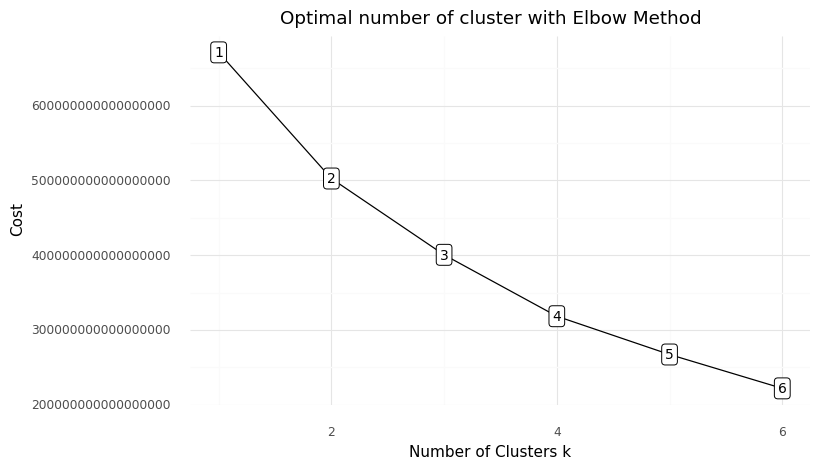

<ggplot: (8726432454819)>

In [ ]:
# Visualize Optimal K 
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

#### Cluster Model Fitting

In [ ]:
# Modeling with Optimal K as above (Takes about 1 hour to run)

kproto = KPrototypes(n_jobs = -1, n_clusters = 3, random_state = 0)
clusters = kproto.fit_predict(dfMatrix, categorical=catColumnsPos)

In [ ]:
# Cluster centorid
kproto.cluster_centroids_

array([[5.44000438e-02, 5.92063415e-01, 4.87871776e-01, 1.15597477e-01,
        2.31337563e-01, 2.91976498e-01, 2.10980817e-02, 4.85644543e-04,
        2.60339887e-02, 2.80642097e-02, 1.46260562e-02, 1.22106207e-02,
        1.81531731e-02, 2.00000000e+00, 2.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 9.00000000e+00, 1.14000000e+02,
        0.00000000e+00, 0.00000000e+00],
       [5.50498346e-02, 7.28500678e-01, 4.09439243e-01, 9.82512848e-02,
        2.24616968e-01, 2.15706059e-01, 2.20171718e-02, 1.11984890e-03,
        2.58434229e-02, 2.85933287e-02, 1.51170779e-02, 1.16862975e-02,
        1.81956691e-02, 2.00000000e+00, 1.42108479e+00, 2.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 9.00000000e+00, 9.90000000e+01,
        0.00000000e+00, 0.00000000e+00],
       [5.74242007e-02, 3.02174762e-01, 4.66932291e-01, 1.12538806e-01,
        2.32940906e-01, 1.80977112e-01, 2.32249129e-02, 8.07008286e-04,
        3.13324792e-02, 3.41470502e-02, 1.50963077e-02

In [ ]:
# Cluster Similarity score using calinski_harabasz_score
## https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6 
import sklearn 

print(sklearn.metrics.calinski_harabasz_score(norm_df, kproto.labels_))

410.9888333332531


In [ ]:
print(sklearn.metrics.davies_bouldin_score(norm_df, kproto.labels_))

17.285855374756494


In [ ]:
# Add the cluster to the dataframe
norm_df['Cluster Labels'] = kproto.labels_
print(norm_df)

        los   age  height  weight   bmi  race  marital_status  insurance  \
0     0.032 0.012   0.413   0.090 0.199 0.000           1.422      0.000   
4     0.045 0.024   0.587   0.140 0.251 3.000           0.000      0.000   
7     0.027 0.037   0.558   0.135 0.249 0.000           1.422      0.000   
9     0.015 0.049   0.459   0.170 0.229 0.000           0.000      0.000   
10    0.024 0.049   0.459   0.086 0.229 0.000           0.000      0.000   
...     ...   ...     ...     ...   ...   ...             ...        ...   
78102 0.153 0.598   0.317   0.089 0.224 2.000           2.000      2.000   
78106 0.012 0.890   0.459   0.087 0.229 2.000           1.422      2.000   
78108 0.010 0.366   0.490   0.118 0.237 0.000           2.000      0.000   
78109 0.122 0.390   0.394   0.068 0.155 1.000           0.000      0.000   
78111 0.034 0.683   0.394   0.083 0.187 2.000           1.422      2.000   

       fluent_english  gender  ...  avg_sofa  hidden_hypoxemia_percentage  \
0         

In [ ]:
# EVALUATE CLUSTERS
# Compute the silhouette scores 
from sklearn.metrics import silhouette_score

kproto_silhouette = silhouette_score(dfMatrix.tolist(), kproto.labels_).round(2)
print(kproto_silhouette)

-0.05


#### Cluster Interpretation

In [ ]:
# Cluster interpretation

table = norm_df.groupby('Cluster Labels').agg(
    {  
        'frequency_of_oral_care_hour__condensed': 'mean',
        'oral_care_type': lambda x: x.value_counts().index[0],
        'los': 'mean',
        'age': 'mean',
        'height': 'mean',
        'weight': 'mean',
        'bmi': 'mean',
        'race': lambda x: (x.value_counts().index[0]),
        'marital_status': lambda x: (x.value_counts().index[0]),
        'insurance': lambda x: (x.value_counts().index[0]),

        'fluent_english': lambda x: (x.value_counts().index[0]),
        'gender': lambda x: (x.value_counts().index[0]),
        'hospital_expire_flag': lambda x: (x.value_counts().index[0]),
        'primary_diagnosis': lambda x: (x.value_counts().index[0]),
        'icd_version': lambda x: (x.value_counts().index[0]),
         
        'avg_sofa': 'mean',
        'hidden_hypoxemia_percentage': 'mean',
        'max_delta_SaO2SpO2': 'mean',

        'intubation_duration_hour': 'mean',
        'number_of_turning': 'mean',
        'frequency_of_turning_hour': 'mean',
        'number_of_oral_care__condensed': 'mean',
        
        
        
    }
).reset_index()

print(table.to_latex())

#### Look Up ICD Diagnosis Codes
Using Map from Leo Team Github

In [ ]:
icd_map = {
    "001-139": "Certain infectious and parasitic diseases",
    "140-239": "Neoplasms",
    "240-279": "Endocrine, nutritional and metabolic diseases",
    "280-289": "Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism",
    "290-319": "Mental and behavioural disorders",
    "320-389": "Diseases of the nervous system",
    "390-459": "Diseases of the circulatory system",
    "460-519": "Diseases of the respiratory system",
    "520-579": "Diseases of the digestive system",
    "580-629": "Diseases of the genitourinary system",
    "630-679": "Pregnancy, childbirth and the puerperium",
    "680-709": "Diseases of the skin and subcutaneous tissue",
    "710-739": "Diseases of the musculoskeletal system and connective tissue",
    "740-759": "Congenital malformations, deformations and chromosomal abnormalities",
    "760-779": "Certain conditions originating in the perinatal period",
    "780-799": "Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",
    "800-999": "Injury, poisoning and certain other consequences of external causes",
    "E80-E99": "Supplementary Classification of External Causes of Injury and Poisoning",
    "V01-V82": "Supplementary Classification of Factors influencing Health Status and Contact with Health Services",
    "M80-M99": "Morphology of Neoplasms"
}

Mapping ICD codes 


*   Cluster primary Diagnosis(114, 99, 15): all within the ICD code group of "Certain infectious and parasitic diseases"
*   Overall Data primary diagnosis = same as above group but outlier group is "Neoplasms"



#### Cluster Visualization 

In [ ]:
# Visualize features
import plotly.express as px
fig = px.scatter_matrix(norm_df, width=1200, height=1600)
fig.show()

In [ ]:
fig2 = px.scatter_3d(norm_df, x="age", y="insurance",z="los",
                     color="Cluster Labels")
fig2.update_layout(title="3 Features Representation")
fig2.show()

In [ ]:
fig3 = px.scatter_3d(norm_df, x="age", y="avg_sofa",z="number_of_turning",
                     color="Cluster Labels")
fig3.update_layout(title="3 Features Representation")
fig3.show()

In [ ]:
print(scat.legend_elements(num=3)[0])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scat = ax.scatter(embedding[0][:, 0], embedding[0][:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
ax.legend(scat.legend_elements(num=3)[0], ['0', '1', '2'],
                    loc="lower left", title="Clusters")
#ax.add_artist(legend1)

#### Cluster Analysis for 3 Clusters

In [ ]:
from collections import Counter

turning_means = {}
ocare_means = {}
clusters = cluster_df.groupby('Cluster Labels')
counter = -1
for key, item in clusters:
  counter += 1
  plt.figure()
  c = clusters.get_group(key)
  plt.bar(Counter(c['race'].tolist()).keys(), Counter(c['race'].tolist()).values())
  plt.title('Cluster Number: '+ str(counter+1) + ' of 3 Race Counts')
  plt.show()

  turning_means[counter] = np.mean(c['frequency_of_turning_hour'])
  ocare_means[counter] = np.mean(c['frequency_of_oral_care_hour__condensed'])

In [ ]:
plt.figure()
plt.scatter(turning_means.keys(), turning_means.values())
plt.title('Cluster turning means')
plt.show()

In [ ]:
plt.figure()
plt.scatter(ocare_means.keys(), ocare_means.values())
plt.title('Cluster oral care means')
plt.show()

In [ ]:

counter = -1
for key, item in clusters:
  counter += 1
  plt.figure()
  c = clusters.get_group(key)
  plt.bar(Counter(c['insurance'].tolist()).keys(), Counter(c['insurance'].tolist()).values())
  plt.title('Cluster Number: '+ str(counter) + ' Insurance Counts')
  plt.show()


In [ ]:
counter = -1
for key, item in clusters:
  counter += 1
  plt.figure()
  c = clusters.get_group(key)
  plt.bar(Counter(c['marital_status'].tolist()).keys(), Counter(c['marital_status'].tolist()).values())
  plt.title('Cluster Number: '+ str(counter) + ' of 3 Marital Status Counts')
  plt.show()

In [ ]:
counter = -1
for key, item in clusters:
  counter += 1
  plt.figure()
  c = clusters.get_group(key)
  plt.bar(Counter(c['fluent_english'].tolist()).keys(), Counter(c['fluent_english'].tolist()).values())
  plt.title('Cluster Number: '+ str(counter) + ' of 3 English Fluency Counts')
  plt.show()

In [ ]:

counter = -1
for key, item in clusters:
  counter += 1
  plt.figure()
  c = clusters.get_group(key)
  plt.bar(Counter(c['gender'].tolist()).keys(), Counter(c['gender'].tolist()).values())
  plt.title('Cluster Number: '+ str(counter) + ' of 3 Gender Counts')
  plt.show()

#### Attempting PCA on Clusters


In [ ]:
## Run PCA on clusters to find significance 

# 1. Data PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(cluster_df)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['1', '2'])

In [ ]:
# 2. 
finalDf = pd.concat([principalDf, cluster_df[['Cluster Labels']]], axis = 1)

In [ ]:
# VISUALIZE PCA *** 3D space??? ***
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Cluster Labels'] == target
    ax.scatter(finalDf.loc[indicesToKeep, '1']
               , finalDf.loc[indicesToKeep, '2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Linear Regression 
We train two different models one on white patients and the other on nonwhite patient data. Then we compared their performance on predicitng turning frequency. 

In [ ]:
#Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

In [ ]:
# Replace all NaN Values with Mean
stats = df.describe()
new_df = df.copy()

for col in df.columns:
  for i in df[col].isnull().to_numpy().nonzero():
    
    new_df[col].iloc[i] = stats[col]['mean']

print(np.argwhere(np.isnan(new_df.to_numpy())))

In [ ]:
# Split the Data into White or Non-White

race_map = {} 
for i, race in enumerate(new_df.race.unique()):
  if 2 == race:
    race_map[race] = 0
  else:
    race_map[race] = 1

groups = new_df.groupby('race')

white_df = groups.get_group(0)
nonwhite_df = groups.get_group(1)

In [ ]:
print(np.shape(white_df))
print(np.shape(nonwhite_df))

In [ ]:
#  Split into Train + Validation + Test

# WHITE
subject_id = list(set(white_df.subject_id))
subject_id_train = subject_id[:int(len(subject_id) * 0.7)]
subject_id_val = subject_id[int(len(subject_id) * 0.7): int(len(subject_id) * 0.8)]
subject_id_test = subject_id[int(len(subject_id) * 0.8):]

white_train_df = white_df[white_df.subject_id.isin(subject_id_train)]
white_val_df = white_df[white_df.subject_id.isin(subject_id_val)]
white_test_df = white_df[white_df.subject_id.isin(subject_id_test)]

# NON-WHITE
subject_id = list(set(nonwhite_df.subject_id))
subject_id_train = subject_id[:int(len(subject_id) * 0.7)]
subject_id_val = subject_id[int(len(subject_id) * 0.7): int(len(subject_id) * 0.8)]
subject_id_test = subject_id[int(len(subject_id) * 0.8):]

nonwhite_train_df = nonwhite_df[nonwhite_df.subject_id.isin(subject_id_train)]
nonwhite_val_df = nonwhite_df[nonwhite_df.subject_id.isin(subject_id_val)]
nonwhite_test_df = nonwhite_df[nonwhite_df.subject_id.isin(subject_id_test)]

In [ ]:
# Prep Data Sets for each linear regression

# 1. Predict Turning Frequency 
white_turn_train = white_train_df['frequency_of_turning_hour'].values
white_train_turn_df = white_train_df.drop(columns=['frequency_of_turning_hour', 'number_of_turning'])

nonwhite_turn_train = nonwhite_train_df['frequency_of_turning_hour'].values
nonwhite_train_turn_df = nonwhite_train_df.drop(columns=['frequency_of_turning_hour', 'number_of_turning'])


In [ ]:
# Perform the Linear Regression

# White Model 
clf = LinearRegression()
clf.fit(white_train_turn_df, white_turn_train)

white_turn_val = white_val_df['frequency_of_turning_hour'].values
white_val_turn_df = white_val_df.drop(columns=['frequency_of_turning_hour','number_of_turning'])
white_pred_val = clf.predict(white_val_turn_df.to_numpy())

# NonWhite Model 
clf2 = LinearRegression()
clf2.fit(nonwhite_train_turn_df, nonwhite_turn_train)

nonwhite_turn_val = nonwhite_val_df['frequency_of_turning_hour'].values
nonwhite_val_turn_df = nonwhite_val_df.drop(columns=['frequency_of_turning_hour','number_of_turning'])
nonwhite_pred_val = clf2.predict(nonwhite_val_turn_df.to_numpy())

In [ ]:
# Rounded Accuracy 
# https://realpython.com/python-rounding/#rounding-up 
import math

def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

def rounded_reg_accuracy(true, pred):
  total = len(true)
  correct = 0
  for t in range(len(true)):
    if round_half_up(true[t], 1) == round_half_up(pred[t], 1):
      correct += 1
  return correct / total 

def forgiving_reg_accuracy(true, pred):
  total = len(true)
  correct = 0
  for t in range(len(true)):
    if pred[t] - 0.1 < true[t] < pred[t] + 0.1:
      correct += 1
  return correct / total 

In [ ]:
print('White Model Accuracy ' + str(rounded_reg_accuracy(white_turn_val, white_pred_val)))
print('NonWhite Model Accuracy ' + str(rounded_reg_accuracy(nonwhite_turn_val, nonwhite_pred_val)))

print('White Model Forgiving Accuracy ' + str(forgiving_reg_accuracy(white_turn_val, white_pred_val)))
print('NonWhite Model Forgiving Accuracy ' + str(forgiving_reg_accuracy(nonwhite_turn_val, nonwhite_pred_val)))

White Model Accuracy 0.3681506849315068
NonWhite Model Accuracy 0.3951271186440678
White Model Forgiving Accuracy 0.6643835616438356
NonWhite Model Forgiving Accuracy 0.6927966101694916


## Logistic Regression

We trained two different models one on white the other on nonwhite patient data to predict if a patient will die in the ICU. Then we compared the performance of these two models. We found that the model trained on the nonwhite patients attained an accuracy that was 6% higher then the white model. 

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

In [ ]:
# Data Preprocessing

# Replace all NaN Values with Mean
stats = df.describe()
new_df = df.copy()

for col in df.columns:
  for i in df[col].isnull().to_numpy().nonzero():
    new_df[col].iloc[i] = stats[col]['mean']

print(np.argwhere(np.isnan(new_df.to_numpy())))


In [ ]:
# Data Splits

# Train, Val, Test Data
subject_id = list(set(new_df.subject_id))
subject_id_train = subject_id[:int(len(subject_id) * 0.7)]
subject_id_val = subject_id[int(len(subject_id) * 0.7): int(len(subject_id) * 0.8)]
subject_id_test = subject_id[int(len(subject_id) * 0.8):]

train_df = new_df[new_df.subject_id.isin(subject_id_train)]
val_df = new_df[new_df.subject_id.isin(subject_id_val)]
test_df = new_df[new_df.subject_id.isin(subject_id_test)]

# Remove IDs
train_df = train_df.drop(['subject_id', 'hadm_id',  'stay_id'], axis=1) 
test_df = test_df.drop(['subject_id', 'hadm_id',  'stay_id'], axis=1)

# Split the Data into White or Non-White for the test set 
race_map = {} 
for i, race in enumerate(new_df.race.unique()):
  if 2 == race:
    race_map[race] = 0
  else:
    race_map[race] = 1

train_groups = train_df.groupby('race')
white_train_df = train_groups.get_group(0)
nonwhite_train_df = train_groups.get_group(1)

groups = test_df.groupby('race')
white_test_df = groups.get_group(0)
nonwhite_test_df = groups.get_group(1)

# Set Predicition task 
white_mort_train = white_train_df['hospital_expire_flag'].values
white_train_mort_df = white_train_df.drop(columns=['hospital_expire_flag'])
nonwhite_mort_train = nonwhite_train_df['hospital_expire_flag'].values
nonwhite_train_mort_df = nonwhite_train_df.drop(columns=['hospital_expire_flag'])

nonwhite_test = nonwhite_test_df['hospital_expire_flag'].values
nonwhite_test_df = nonwhite_test_df.drop(columns=['hospital_expire_flag'])
white_test = white_test_df['hospital_expire_flag'].values
white_test_df = white_test_df.drop(columns=['hospital_expire_flag'])


In [ ]:
# Logistic Regression 
clf = LogisticRegression()
clf.fit(white_train_mort_df, white_mort_train)

clf2 = LogisticRegression()
clf2.fit(nonwhite_train_mort_df, nonwhite_mort_train)

In [ ]:
# Testing 
nonwhite_pred_val = clf2.predict(nonwhite_test_df)
print('AUC: ' + str(roc_auc_score(nonwhite_test, nonwhite_pred_val)))
print('Accuracy: ' + str(accuracy_score(nonwhite_test, [x >= 0.5 for x in nonwhite_pred_val])))

white_pred_val = clf.predict(white_test_df)
print('AUC: ' + str(roc_auc_score(white_test, white_pred_val)))
print('Accuracy: ' + str(accuracy_score(white_test, [x >= 0.5 for x in white_pred_val])))

AUC: 0.5283230001512172
Accuracy: 0.8143459915611815
AUC: 0.5673764541647278
Accuracy: 0.7554991539763113


In [ ]:
# What do we expect to be the biggest factors/weights?
print(np.argmax([abs(x) for x in clf.coef_[0]]))
print(np.argmax([abs(x) for x in clf2.coef_[0]]))

12
12


In [ ]:
print(white_test_df.columns[12])
print(white_test_df.columns[12])

avg_sofa
avg_sofa
